In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.8.0+cu126


In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [3]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attn_scores_2[i] = torch.dot(query, x_i)

print(attn_scores_2)
inputs.shape[0]

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


6

In [4]:
res = 0
for idx, element in enumerate(inputs[0]):
  res += inputs[0][idx] * query[idx]

print(res)
print(attn_scores_2[0])
print("you’ve proven that your manual summation matches the torch.dot calculation.")

tensor(0.9544)
tensor(0.9544)
you’ve proven that your manual summation matches the torch.dot calculation.


In [5]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("attention weights:", attn_weights_2_tmp)
print("sum:", attn_weights_2_tmp.sum())

attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
sum: tensor(1.0000)


In [6]:
def softmax_naive(x):
  return torch.exp(x) / torch.exp(x).sum()

attn_weights_2 = softmax_naive(attn_scores_2)
print("attention weights:", attn_weights_2)
print("sum:", attn_weights_2.sum())

attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum: tensor(1.)


Note that this naive softmax implementation (softmax_naive) may encounter numerical instability problems, such as overflow and underflow, when dealing with large or small input values. Therefore, in practice, it's advisable to use the PyTorch implementation of softmax, which has been extensively optimized for performance:

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=-1)
print("attention weights:", attn_weights_2)
print("sum:", attn_weights_2.sum())

attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum: tensor(1.)


compute the context vector  by multiplying the embedded input tokens,  with the attention weights and sum the resulting vectors:

In [8]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape[0])

for i, i_x in enumerate(inputs):
  context_vec_2 += attn_weights_2[i] * i_x

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


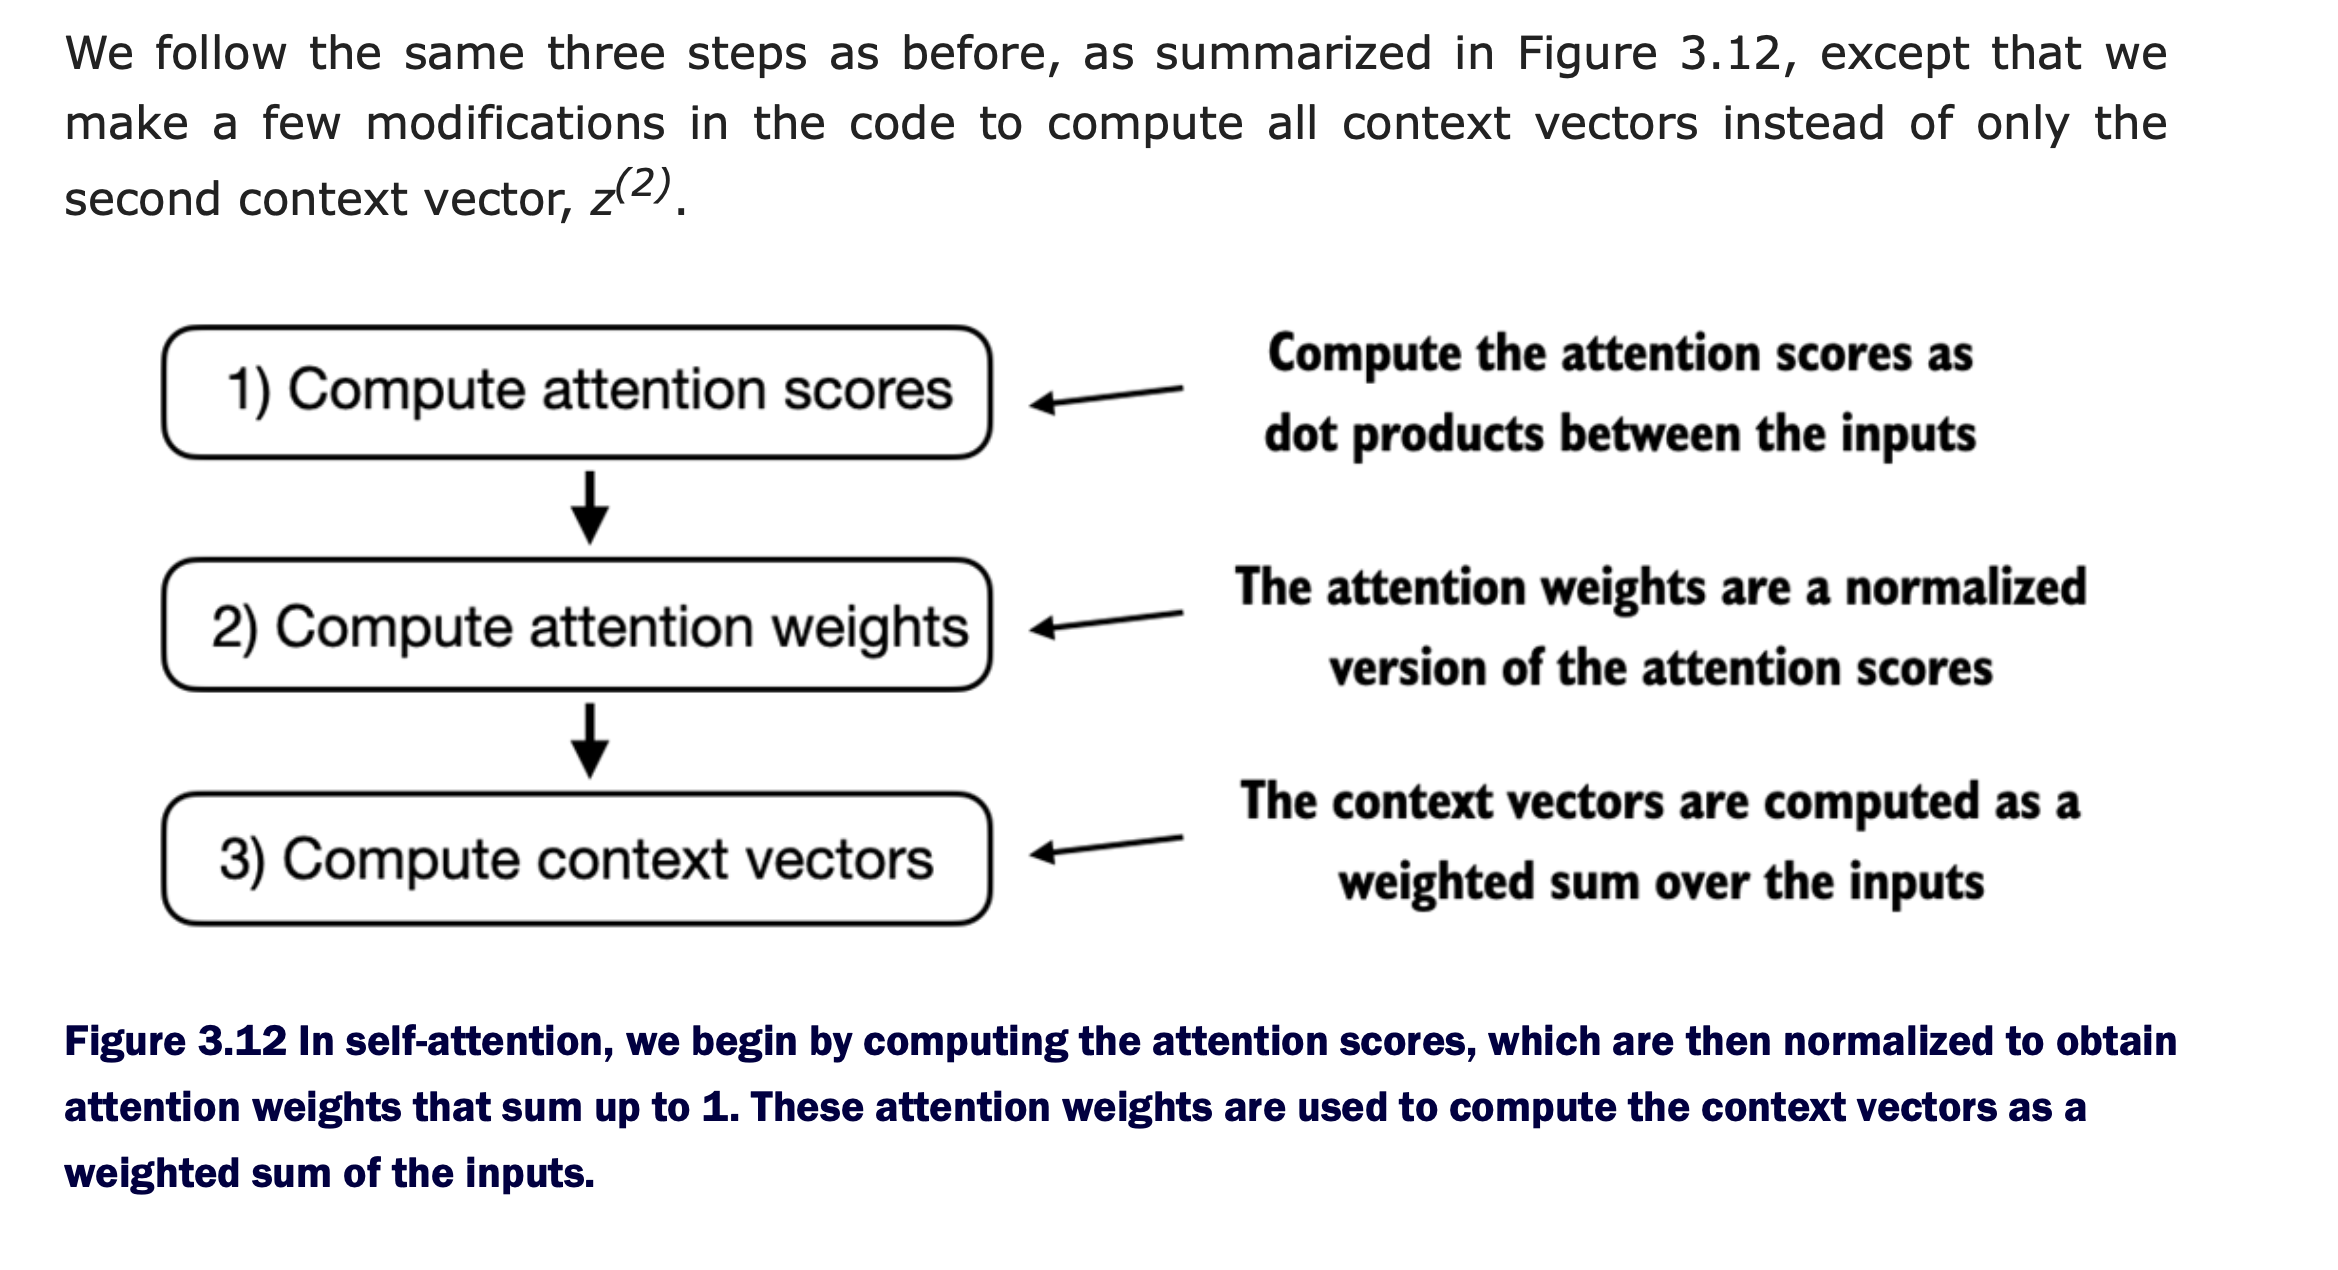

In [9]:
attn_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
  for j, x_j in enumerate(inputs):
    attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [10]:
attn_scores = inputs @ inputs.T # @:matrix multiplication
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [11]:
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [12]:
raw_1_sum = attn_weights[0].sum()
print(raw_1_sum)
print("All row sums:", attn_weights.sum(dim=-1))

tensor(1.0000)
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [13]:
all_context_vector = attn_weights @ inputs
print(all_context_vector)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


**3.4.1 Computing the attention weights step by step**

In this section, we are implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs

the input and output dimensions are usually the same, but for illustration purposes, to better follow the computation, we choose different input (d_in=3) and output (d_out=2) dimensions here.

In [14]:
x_2 = inputs[1]   # second input element
d_in = inputs.shape[1]    # the input embedding size, d=3
d_out = 2   # the output embedding size, d=2

 we initialize the three weight matrices Wq, Wk, and Wv

Note that we are setting requires_grad=False to reduce clutter in the outputs for illustration purposes, but if we were to use the weight matrices for model training, we would set requires_grad=True to update these matrices during model training.


In [15]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [16]:
query_2 = x_2 @ W_query
key_2   = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)
print(key_2)
print(value_2)

tensor([0.4306, 1.4551])
tensor([0.4433, 1.1419])
tensor([0.3951, 1.0037])


In [17]:
keys = inputs @ W_key
values = inputs @ W_value
print("As we can tell from the outputs, we successfully projected the 6 input tokens from a 3D onto a 2D embedding space:")
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)
print("keys:", keys)


As we can tell from the outputs, we successfully projected the 6 input tokens from a 3D onto a 2D embedding space:
keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
keys: tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])


In [18]:
attn_score_22 = query_2.dot(key_2)
print(attn_score_22)

tensor(1.8524)


we can generalize this computation to all attention scores via matrix multiplication:

In [19]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [20]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


In [21]:
context_vector_2 = attn_weights_2 @ values
print(context_vector_2)

tensor([0.3061, 0.8210])


**3.4.2 Implementing a compact SelfAttention class**

Putting it all together, we can implement the self-attention mechanism as follows:


In [22]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__ (self, d_in, d_out):
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(d_in, d_out))
    self.W_key = nn.Parameter(torch.rand(d_in, d_out))
    self.W_value = nn.Parameter(torch.rand(d_in, d_out))

  def forward(self, X):
    keys = X @ self.W_key
    values = X @ self.W_value
    queries = X @ self.W_query

    attn_scores = queries @ keys.T
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    context_vec = attn_weights @ values
    return context_vec


In [23]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's nn.Linear layers, which effectively perform matrix multiplication when the bias units are disabled. Additionally, a significant advantage of using nn.Linear instead of manually implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight initialization scheme, contributing to more stable and effective model training.

In [24]:
class SelfAttention_v2(nn.Module):
  def __init__ (self, d_in, d_out, qkv_bias = False):
    super(). __init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)


  def forward(self, x):
     keys = self.W_key(x)
     queries = self.W_query(x)
     values = self.W_value(x)


     attn_scores = queries @ keys.T
     attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
     context_vec = attn_weights @ values
     return context_vec

In [25]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they use different initial weights for the weight matrices since nn.Linear uses a more sophisticated weight initialization scheme.

**3.5 Hiding future words with causal attention**

In this section, we modify the standard self-attention mechanism to create a causal attention mechanism, which is essential for developing an LLM in the subsequent chapters.

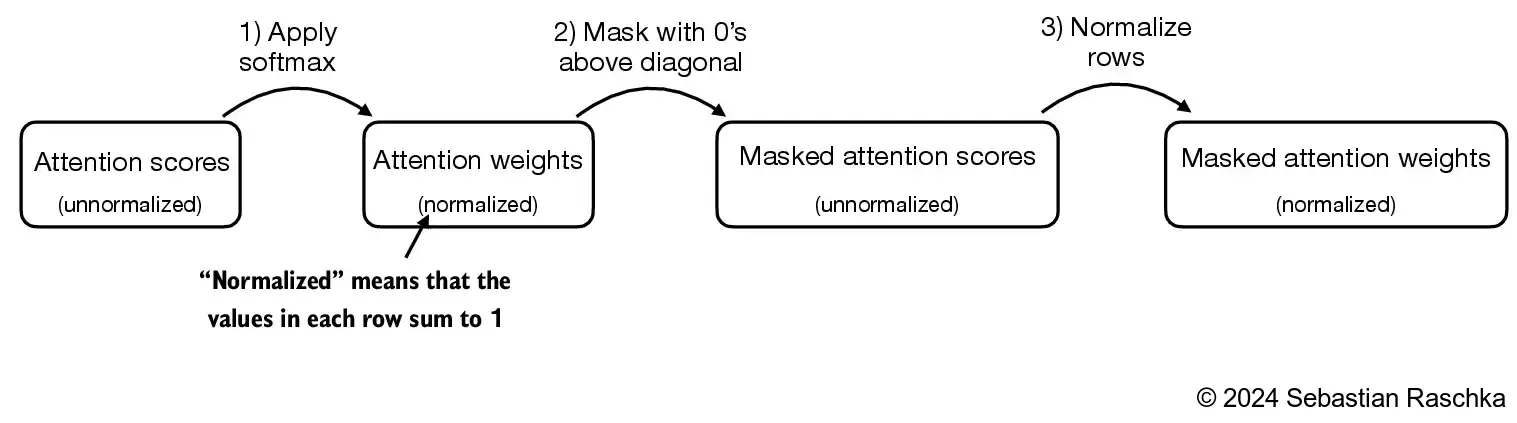

In [26]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [27]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [28]:
masked_simple = mask_simple * attn_weights
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


The third step in Figure 3.20 is to renormalize the attention weights to sum up to 1 again in each row. We can achieve this by dividing each element in each row by the sum in each row:

In [29]:
row_sum = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sum
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


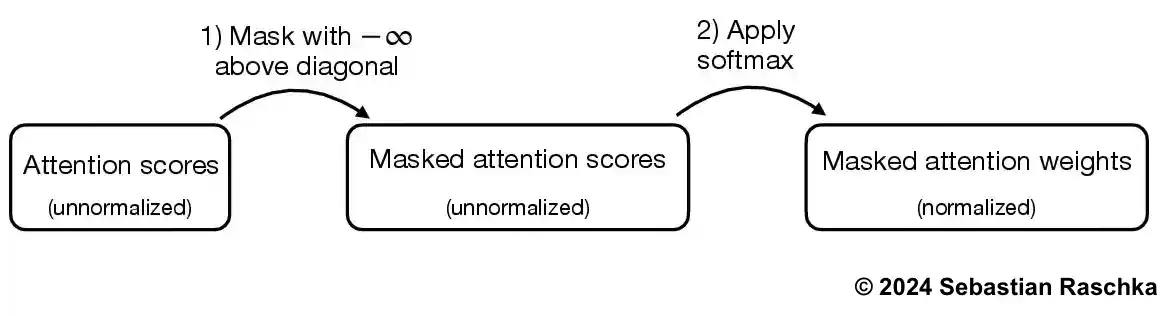

While we could be technically done with implementing causal attention at this point, we can take advantage of a mathematical property of the softmax function and implement the computation of the masked attention weights more efficiently in fewer steps, as shown in Figure

* While we are technically done with coding the causal attention mechanism now, let's briefly look at a more efficient approach to achieve the same as above
* So, instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function:

In [30]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [31]:
attn_weights = torch.softmax(masked / keys.shape[-1], dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5366, 0.4634, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3660, 0.3168, 0.3172, 0.0000, 0.0000, 0.0000],
        [0.2681, 0.2473, 0.2474, 0.2371, 0.0000, 0.0000],
        [0.2123, 0.1988, 0.1989, 0.1920, 0.1980, 0.0000],
        [0.1853, 0.1665, 0.1667, 0.1578, 0.1667, 0.1569]],
       grad_fn=<SoftmaxBackward0>)


**3.5.2 Masking additional attention weights with dropout**

* In addition, we also apply dropout to reduce overfitting during training

In the transformer architecture, including models like GPT, dropout in the attention mechanism is typically applied in two specific areas: after calculating the attention scores or after applying the attention weights to the value vectors.
Here, we will apply the dropout mask after computing the attention weights


In the following code example, we use a dropout rate of 50%, which means masking out half of the attention weights. (When we train the GPT model in later chapters, we will use a lower dropout rate, such as 0.1 or 0.2.)

In [32]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


When applying dropout to an attention weight matrix with a rate of 50%, half of the elements in the matrix are randomly set to zero. To compensate for the reduction in active elements, the values of the remaining elements in the matrix are scaled up by a factor of 1/0.5 =2. This scaling is crucial to maintain the overall balance of the attention weights, ensuring that the average influence of the attention mechanism remains consistent during both the training and inference phases.

In [33]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7321, 0.6335, 0.6344, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4946, 0.4949, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3977, 0.0000, 0.3840, 0.0000, 0.0000],
        [0.0000, 0.3331, 0.3334, 0.3157, 0.3334, 0.0000]],
       grad_fn=<MulBackward0>)


**3.5.3 Implementing a compact causal attention class**

In [34]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


we will now incorporate the causal attention and dropout modifications into the SelfAttention Python class we developed in section 3.4. This class will then serve as a template for developing multi-head attention in the upcoming section, which is the final attention class we implement in this chapter.

In [35]:
class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out,context_length ,dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    values = self.W_value(x)
    queries = self.W_query(x)

    attn_scores = queries @ keys.transpose(1,2)
    attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)
    context_vec = attn_weights @ values
    return context_vec


In [36]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vec = ca(batch)
print(context_vec.shape)

torch.Size([2, 6, 2])


**3.6 Extending single-head attention to multi-head attention**

**3.6.1 Stacking multiple single-head attention layers**


* Below is a summary of the self-attention implemented previously (causal and dropout masks not shown for simplicity)

* This is also called single-head attention: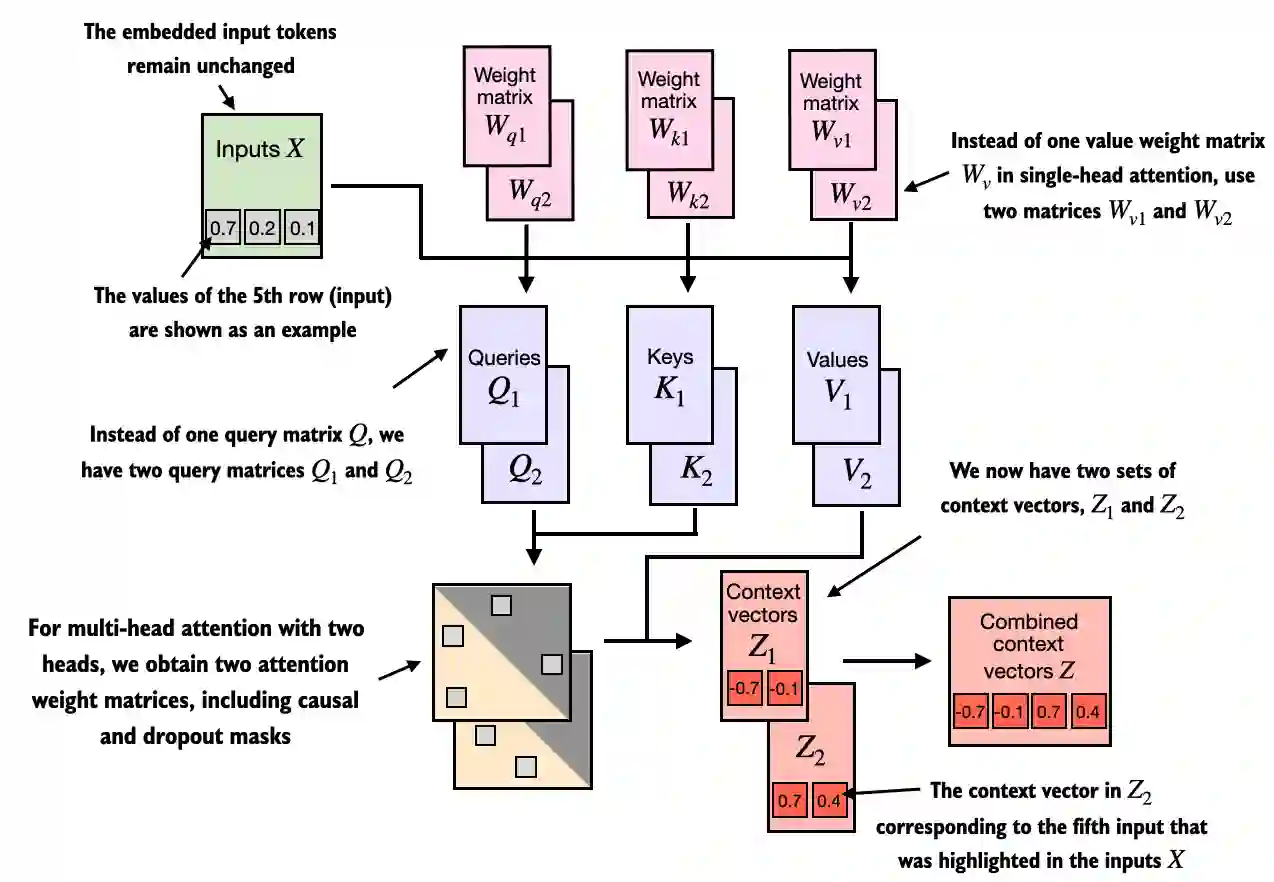

* We simply stack multiple single-head attention modules to obtain a multi-head attention module:


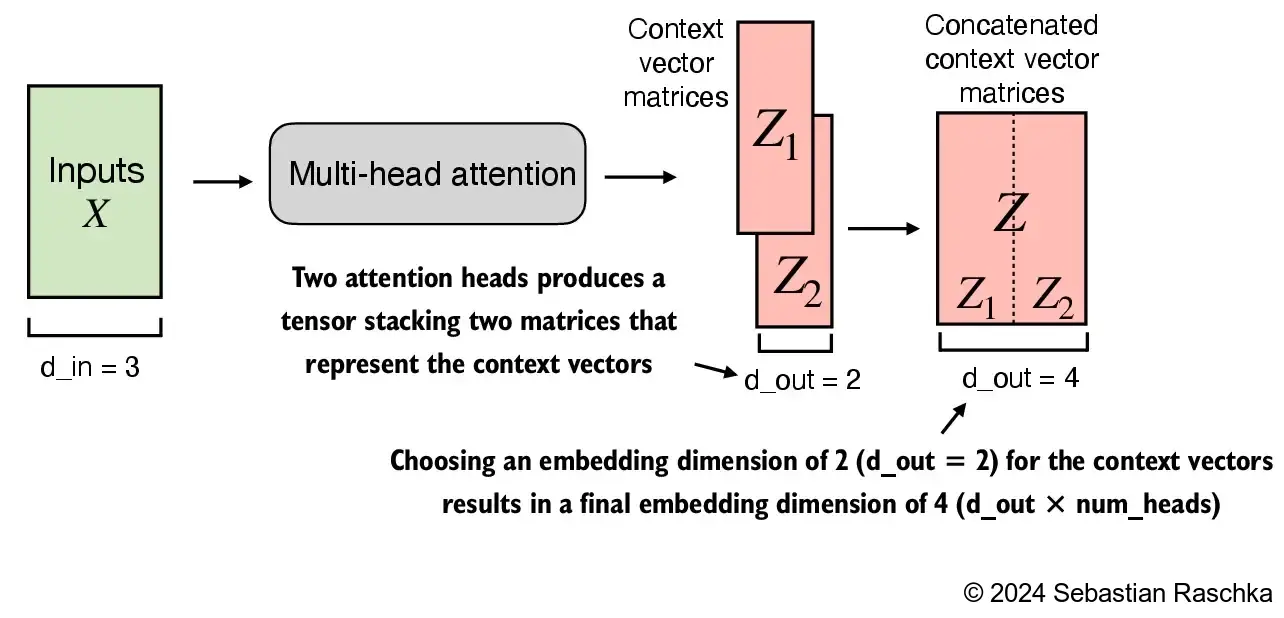

* The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.

In [37]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.heads = nn.ModuleList(
        CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
                        for _ in range(num_heads))


  def forward(self, x):
    return torch.cat([head(x) for head in self.heads], dim=-1)



In [38]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs.shape)

torch.Size([2, 6, 4])


* In the implementation above, the embedding dimension is 4, because we d_out=2 as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4

**3.6.2 Implementing multi-head attention with weight splits**

Instead of maintaining two separate classes, MultiHeadAttentionWrapper and CausalAttention, we can combine both of these concepts into a single MultiHeadAttention class. Also, in addition to just merging the MultiHeadAttentionWrapper with the CausalAttention code, we will make some other modifications to implement multi-head attention more efficiently.


In [45]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    values = self.W_value(x)
    queries = self.W_query(x)


    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1, 2)
    values = values.transpose(1, 2)
    queries = queries.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2)
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vec)
    return context_vec

Even though the reshaping (.view) and transposing (.transpose) of tensors inside the MultiHeadAttention class looks very complicated, mathematically, the MultiHeadAttention class implements the same concept as the MultiHeadAttentionWrapper earlier.
On a big-picture level, in the previous MultiHeadAttentionWrapper, we stacked multiple single-head attention layers that we combined into a multi-head attention layer. The MultiHeadAttention class takes an integrated approach. It starts with a multi-head layer and then internally splits this layer into individual attention heads, as illustrated in Figure

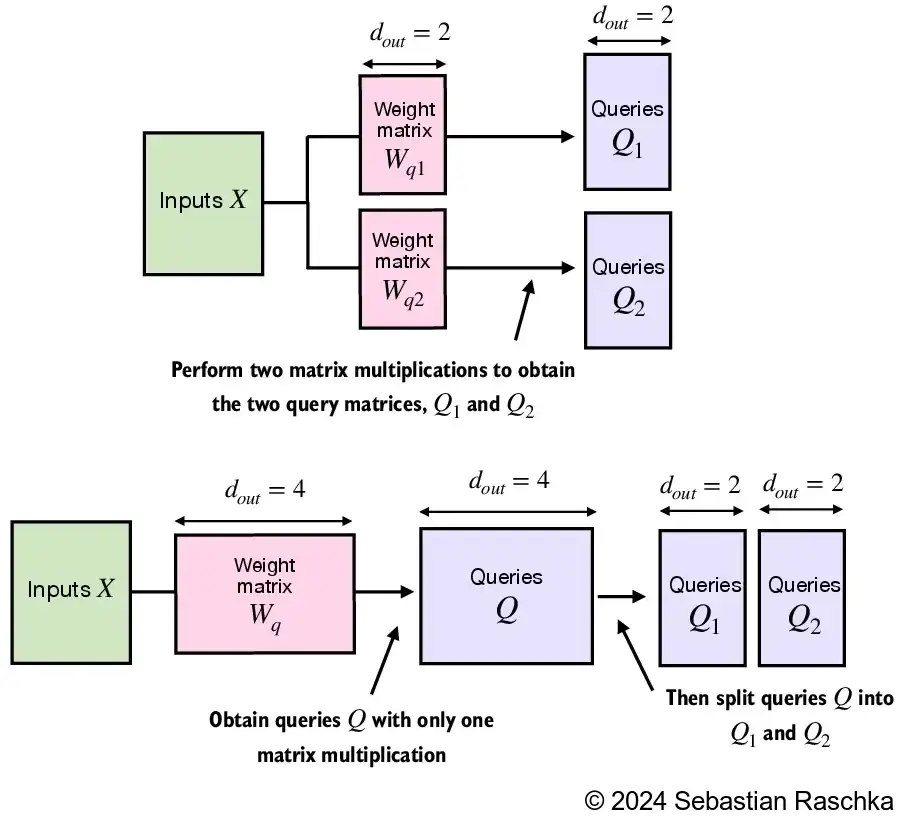

Figure: In the MultiheadAttentionWrapper class with two attention heads, we initialized two weight matrices Wq1 and Wq2 and computed two query matrices Q1 and Q2 as illustrated at the top of this figure. In the MultiheadAttention class, we initialize one larger weight matrix Wq , only perform one matrix multiplication with the inputs to obtain a query matrix Q, and then split the query matrix into Q1 and Q2 as
shown at the bottom of this figure. We do the same for the keys and values, which are not shown to reduce visual clutter.

The splitting of the query, key, and value tensors, as depicted in Figure 3.26, is achieved through tensor reshaping and transposing operations using PyTorch's .view and .transpose methods. The input is first transformed (via linear layers for queries, keys, and values) and then reshaped to represent multiple heads.
The key operation is to split the d_out dimension into num_heads and head_dim, where head_dim = d_out / num_heads. This splitting is then achieved using the .view method: a tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens, num_heads, head_dim).

The tensors are then transposed to bring the num_heads dimension before the num_tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim). This transposition is crucial for correctly aligning the queries, keys, and values across the different heads and performing batched matrix multiplications efficiently.
To illustrate this batched matrix multiplication, suppose we have the following example tensor:

In [40]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],             #A
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],
                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])
a.shape

torch.Size([1, 2, 3, 4])


Now, we perform a batched matrix multiplication between the tensor itself and a view of the tensor where we transposed the last two dimensions, num_tokens and head_dim:

In [41]:
print(a @ a.transpose(2,3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In this case, the matrix multiplication implementation in PyTorch handles the 4-dimensional input tensor so that the matrix multiplication is carried out between the 2 last dimensions (num_tokens, head_dim) and then repeated for the individual heads.
For instance, the above becomes a more compact way to compute the matrix multiplication for each head separately:

In [46]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("first head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("second head:\n", second_res)

first head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])
second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


The results are exactly the same results that we obtained when using the batched matrix multiplication print(a @ a.transpose(2, 3)) earlier

In [47]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])
